In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 1.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/26 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N26.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N5.jpg
/kaggle/input/brain-mri-images-for-b

In [2]:
#Libraries for processing
import os
from PIL import Image
from glob import glob
import cv2
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import warnings 
warnings.filterwarnings("ignore")
#Libraries for model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D ,GlobalAveragePooling2D ,MaxPooling2D , Input ,Flatten , Dense ,Dropout , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
print("Done")

2025-08-12 17:41:23.609583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755020483.869123      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755020483.940538      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Done


In [3]:
dataset_path = Path("/kaggle/input/brain-mri-images-for-brain-tumor-detection")
yes_path = dataset_path / "yes"    #TUMOR
no_path = dataset_path / "no"     #NO TUMOR

extensions = set()

def collect_extensions(folder_path):
    for file in os.listdir(folder_path):
        if os.path.isfile(folder_path / file):  
            ext = Path(file).suffix.lower()
            extensions.add(ext)

collect_extensions(yes_path)
collect_extensions(no_path)

image_extensions = tuple(extensions)

#counting YES AND NO LABELS

yes_count = len([file for file in os.listdir(yes_path) if file.lower().endswith(image_extensions)])
no_count = len([file for file in os.listdir(no_path) if file.lower().endswith(image_extensions)])


print(f"Count of yes labels: {yes_count}")
print(f"Count of no labels: {no_count}") 

Count of yes labels: 155
Count of no labels: 98


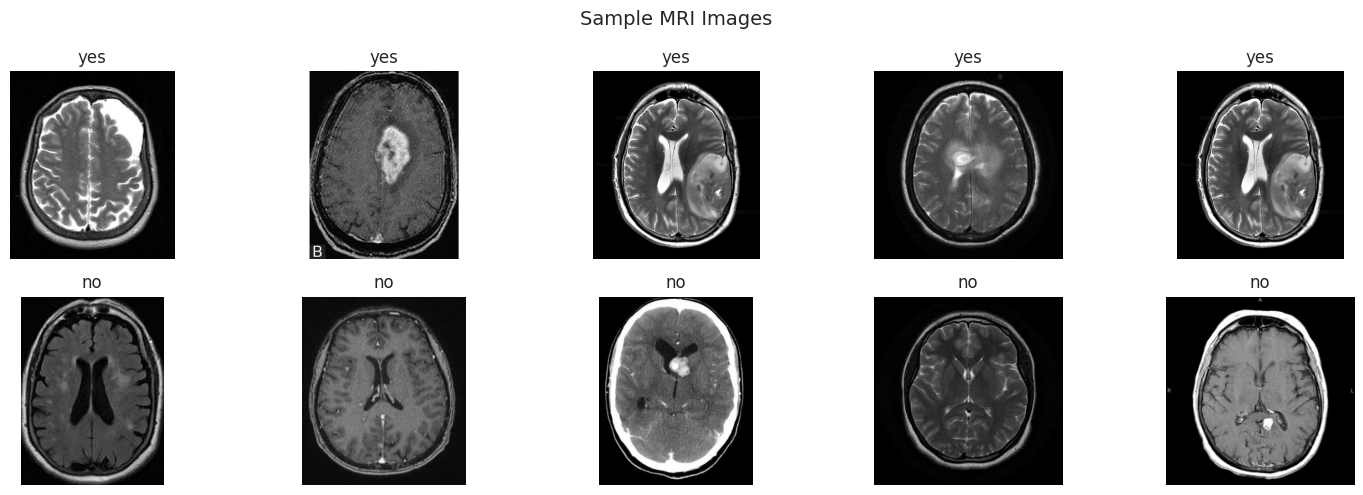

In [4]:
plt.figure(figsize=(15, 5))
img_index = 1

for label in ["yes", "no"]:
    folder = dataset_path / label
    images = [f for f in os.listdir(folder) if f.lower().endswith(image_extensions)]
    
    for img_name in images[:5]: 
        img_path = folder / img_name
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, 5, img_index)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
        img_index += 1

plt.suptitle("Sample MRI Images", fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
#df
image_paths = []
labels = []

for label in ["yes", "no"]:
    folder = dataset_path / label
    for img_file in os.listdir(folder):
        image_paths.append(str(folder / img_file))
        labels.append(label)

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

df.head()

,image_path,label
0,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
1,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
2,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
3,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
4,/kaggle/input/brain-mri-images-for-brain-tumor...,yes


In [6]:
temp_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, valid_df = train_test_split(temp_df, test_size=0.1, stratify=temp_df['label'], random_state=42)

In [7]:
batch_size=32
img_size=(224,224)
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='label',
                                        target_size=img_size, class_mode='binary',
                                        shuffle=True, batch_size=batch_size)

valid_gen = datagen.flow_from_dataframe(valid_df, x_col='image_path', y_col='label',
                                        target_size=img_size, class_mode='binary',
                                        shuffle=False, batch_size=batch_size)

test_gen = datagen.flow_from_dataframe(test_df, x_col='image_path', y_col='label',
                                       target_size=img_size, class_mode='binary',
                                       shuffle=False, batch_size=batch_size)

Found 181 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [8]:
input_layer = Input(shape=(224, 224, 3))

base_resnet = ResNet50(include_top=False, 
                      weights='imagenet',
                      input_tensor=input_layer)
base_resnet.trainable = False

model_resnet = Sequential([
   base_resnet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_resnet.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_resnet.summary()


2025-08-12 17:41:41.528341: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,136,961 (92.08 MB)

 Trainable params: 545,153 (2.08 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", monitor='val_loss',save_best_only=True)
]

In [10]:
epochs = 30
history = model_resnet.fit(train_gen, 
                           epochs= epochs,
                           callbacks=callbacks,
                           verbose= 1,
                           validation_data= valid_gen
                          )

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.5085 - loss: 1.1818 - val_accuracy: 0.3810 - val_loss: 0.7416
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5766 - loss: 0.9285 - val_accuracy: 0.6667 - val_loss: 0.5799
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6401 - loss: 0.7176 - val_accuracy: 0.8571 - val_loss: 0.4757
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7203 - loss: 0.5696 - val_accuracy: 0.9048 - val_loss: 0.4167
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7854 - loss: 0.5137 - val_accuracy: 0.8571 - val_loss: 0.3767
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8195 - loss: 0.4645 - val_accuracy: 0.9048 - val_loss: 0.3507
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8287 - loss: 0.4053 - val_accuracy: 0.9048 - val_loss: 0.3376
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8475 - loss: 0.3888 - val_accuracy: 0.9048 - val_loss: 0.3261
Epoch 9/

In [11]:
model_resnet.save("brain_tumor_classifier_model.keras")

In [12]:
from tensorflow.keras.models import load_model
loaded_model = load_model("brain_tumor_classifier_model.keras")
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,682,116 (94.15 MB)

 Trainable params: 545,153 (2.08 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

 Optimizer params: 545,155 (2.08 MB)

In [13]:
loss, acc = model_resnet.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8039


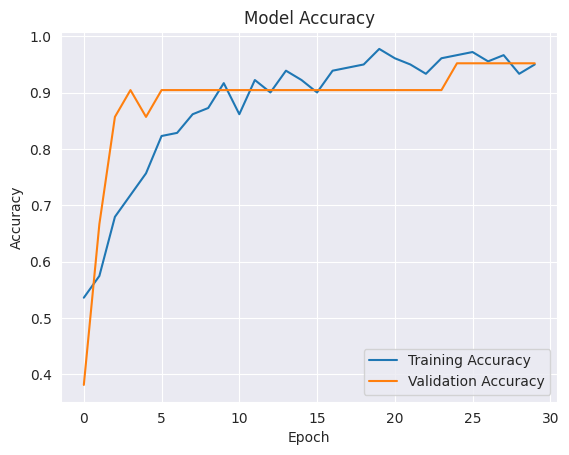

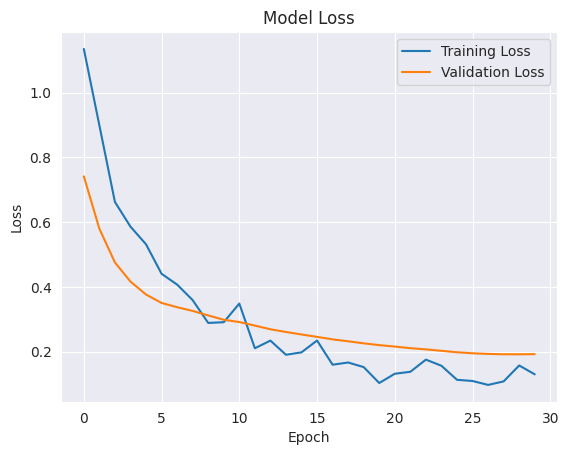

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
y_pred = model_resnet.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype("int32")  
y_true = test_gen.classes

print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
              precision    recall  f1-score   support

          no       0.81      0.65      0.72        20
         yes       0.80      0.90      0.85        31

    accuracy                           0.80        51
   macro avg       0.81      0.78      0.79        51
weighted avg       0.80      0.80      0.80        51



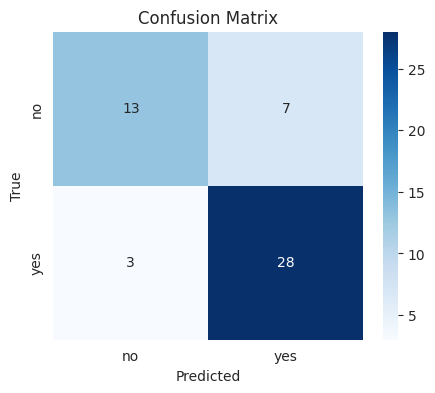

In [16]:
cm = confusion_matrix(test_gen.classes, y_pred_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()